## StateFarm Kaggle Notebook

In [1]:
%matplotlib inline
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '../utils'))
from utils import *
from PIL import Image
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

Using gpu device 0: GeForce GTX 1070 (CNMeM is disabled, cuDNN 5105)
/home/rallen/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data'
categories = sorted([os.path.basename(x) for x in glob(DATA_HOME_DIR+'/train/*')])
categories

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [3]:
def plot_history(h):
    plt.plot(h['acc'])
    plt.plot(h['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def underfit(train_err, test_error):
    return train_err < test_error * 0.667

def overfit(train_acc, test_acc):
    return train_acc > test_acc

def validation_histogram():
    probs = bn_model.predict(conv_val_feat, batch_size=batch_size)
    expected_labels = val_batches.classes
    our_labels = np.argmax(probs, axis=1)
    data = np.vstack([expected_labels, our_labels]).T
    plt.style.use('seaborn-deep')
    plt.hist(data, range(11), alpha=0.7, label=['expected', 'ours'])
    plt.legend(loc='upper right')
    plt.show()
    
def validation_np_histogram():
    probs = bn_model.predict(conv_val_feat, batch_size=batch_size)
    expected_labels = val_batches.classes
    our_labels = np.argmax(probs, axis=1)
    print np.histogram(our_labels,range(11))[0]
    
def validation_confusion():
    probs = bn_model.predict(conv_val_feat, batch_size=batch_size)
    expected_labels = val_batches.classes
    our_labels = np.argmax(probs, axis=1)
    cm = confusion_matrix(expected_labels, our_labels)
    plot_confusion_matrix(cm, val_batches.class_indices)

In [4]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR + '/'
#path = DATA_HOME_DIR + '/sample/'

test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path=DATA_HOME_DIR + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

histories = {}

/home/rallen/Documents/Devel/PracticalDL4C/kaggle/statefarm/data


In [5]:
batch_size=64
(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)
val_batches = get_batches(path+'valid', batch_size=batch_size, shuffle=False)


Found 19669 images belonging to 10 classes.
Found 2755 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.
Found 2755 images belonging to 10 classes.


## Skip this if created conv data to train

In [6]:
# use the batch normalization VGG
#vgg = Vgg16BN()
# No.  He's not using BN yet, so let's just stop that
vgg = Vgg16()

/home/rallen/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:621: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [7]:
model=vgg.model
last_conv_idx = [i for i,l in enumerate(model.layers) if type(l) is Convolution2D][-1]
conv_layers = model.layers[:last_conv_idx+1]
print "input shape to dense layer", conv_layers[-1].output_shape[1:]

input shape to dense layer (512, 14, 14)


In [8]:
conv_model = Sequential(conv_layers)

Original:

    Found 17943 images belonging to 10 classes.
    Found 4481 images belonging to 10 classes.
    Found 79726 images belonging to 1 classes.

In [9]:
gen_t = image.ImageDataGenerator(rotation_range=15, height_shift_range=0.05, 
                shear_range=0.1, channel_shift_range=20, width_shift_range=0.1)
# Hmmm, don't we want to train with more augmented images?
batches = get_batches(path+'train', gen_t, batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)
#test_batches = get_batches(path+'test', batch_size=batch_size*2, shuffle=False)

conv_feat = conv_model.predict_generator(batches, batches.nb_sample)
conv_val_feat = conv_model.predict_generator(val_batches, val_batches.nb_sample)
# With 8GB I get memory error on this.  79k images is too many
# Trying 16GB...bah! I *still* get a memory error.  WTF?  I see 10.6GB out of 16GB used.  
#conv_test_feat = conv_model.predict_generator(test_batches, test_batches.nb_sample)

Found 19669 images belonging to 10 classes.
Found 2755 images belonging to 10 classes.


In [10]:
save_array(path+'results/conv_val_feat.dat', conv_val_feat)
save_array(path+'results/conv_feat.dat', conv_feat)
#save_array(path+'results/conv_test_feat.dat', conv_test_feat)


## Load Conv Net saved features

In [ ]:
conv_feat = load_array(path+'results/conv_feat.dat')
conv_val_feat = load_array(path+'results/conv_val_feat.dat')

### Batchnorm dense layers on pretrained conv layers

In [11]:
def get_bn_layers(p,input_shape):
    return [
        MaxPooling2D(input_shape=input_shape),
        Flatten(),
        Dropout(p/2),
        #Dense(128, activation='relu'),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(10, activation='softmax')
        ]

In [12]:
p=0.5 # wow isn't this high?

In [13]:
bn_model = Sequential(get_bn_layers(p,conv_val_feat.shape[1:]))
bn_model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# starting with super-small lr first
bn_model.optimizer.lr=0.000001
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=1, 
             validation_data=(conv_val_feat, val_labels))

# okay at least with 16GB this is much quicker.  6s vs. 200+ due to swapping.  I"m at 10.6GiB memory.

Train on 19669 samples, validate on 2755 samples
Epoch 1/1
19669/19669 [==============================] - 6s - loss: 3.5726 - acc: 0.1021 - val_loss: 2.6976 - val_acc: 0.1085

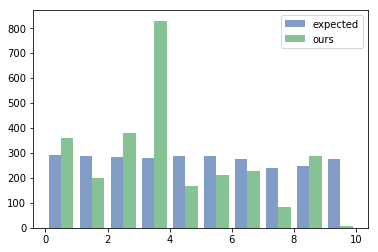

In [15]:
validation_histogram()

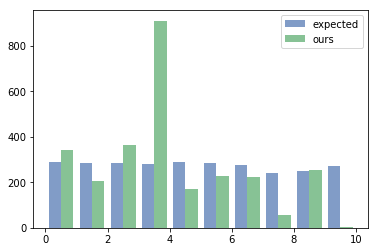

In [17]:
validation_histogram()

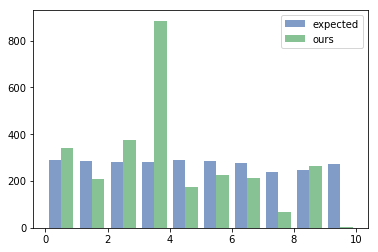

In [19]:
validation_histogram()

Okay, I get a *completely* different result than what he gets.  I'm using the samples, though.  
Let's try with full dataset?

In [ ]:
bn_model.optimizer.lr=0.0001
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=3, 
             validation_data=(conv_val_feat, val_labels))


In [ ]:
validation_histogram()

In [ ]:
validation_histogram()

In [ ]:
validation_histogram()

In [ ]:
validation_confusion()

In [ ]:
hist = bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=5, 
             validation_data=(conv_val_feat, val_labels))


# Vgg16BN code below.

This is older code than above.  For historical reference at the moment...

In [ ]:
#Set constants. You can experiment with no_of_epochs to improve the model
batch_size=64
no_of_epochs=30

In [ ]:
# Augment the data
gen = image.ImageDataGenerator(rotation_range=15, #=0, 
                               height_shift_range=0.05,#=0.1, 
                               width_shift_range=0.1, 
                               shear_range=0.05,#=0
                               channel_shift_range=20,#=0
                               #zoom_range=0.1
                               #, horizontal_flip=True
                              )

In [ ]:
# Finetune the model
# just add gen as 2nd parameter to batches & not val_batches
batches = vgg.get_batches(train_path, gen, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
vgg.finetune(batches)

In [ ]:
INIT_LR0=0.00001
INIT_LR=0.001
EPOCHS_DROP=5.0
DROP=0.5

def step_decay0(epoch, initial_lrate = INIT_LR0, epochs_drop = EPOCHS_DROP, drop = DROP):
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

def step_decay(epoch, initial_lrate = INIT_LR, epochs_drop = EPOCHS_DROP, drop = DROP):
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [ ]:
#latest_weights_filename="weights-02-04-1.00.hdf5"
#vgg.model.load_weights(results_path+latest_weights_filename)

#run_index=0 # restarting fresh
run_index+=1
filepath=results_path+"run-%02d-weights-{epoch:02d}-{val_acc:.2f}.hdf5"%(run_index)
history_filepath=results_path+"run-%02d-history.csv"%(run_index)

checkpoint = ModelCheckpoint(filepath, 
                             #monitor='val_acc', mode='max',
                             monitor='val_loss', mode='min',
                             verbose=1, 
                             save_weights_only=True, save_best_only=True)
lr_scheduler0 = LearningRateScheduler(step_decay0)
lr_scheduler = LearningRateScheduler(step_decay)

callbacks = [checkpoint,lr_scheduler]

In [ ]:
# okay, so he says we need to first start with super-low learning rate just to get things started
history0 = vgg.fit(batches, val_batches, 3, [checkpoint,lr_scheduler0])
# then, let's try again with more reasonable learning rate
history = vgg.fit(batches, val_batches, no_of_epochs, callbacks)
history_df = pd.DataFrame(history.history)
history_df.to_csv(history_filepath)
histories[run_index] = history_df

In [ ]:
histories.keys()

In [ ]:
history_df["underfit"] = map(underfit, history_df["loss"], history_df["val_loss"])
history_df["overfit"] = map(overfit, history_df["acc"], history_df["val_acc"])

plot_history(histories[11])
plot_history(histories[10])

In [ ]:
history_df["underfit"] = map(underfit, history_df["loss"], history_df["val_loss"])
history_df["overfit"] = map(overfit, history_df["acc"], history_df["val_acc"])

plot_history(history_df)

In [ ]:
history_df

## Validate Predictions

In [ ]:
validation_histogram()

In [ ]:
validation_confusion()

In [ ]:
validation_np_histogram()